# Computer Vision, Dr. Aygul Zagidullina, Dr. Dimitris Mousadakos

# Intuitions on Convolutions

Let's build some intuitions about the **`convolution operations`**.

🎯 <b><u>Goals</u>:</b>
- **Understand convolution operations**
- **Visualize**
    - convolution kernels
    - the effects of a convolution kernel applied on images

<hr>

🖼 <b><u>Convolutional Neural Networks are Neural Networks specifically designed to work on images</u></b>.

- 🧮 This is made possible thanks to **`convolution operations`**.

- 🔎 These specific mathematical operations apply a **`filter`** (i.e. a set of **`kernels`**, one per channel) to an input image and create an **`output representation`**. For Convolutional Neural Networks, this can also be called:
    * a **`"convoluted representation/feature"`**,
    * or a **`"convolution"`**,
    * or also an **`"activation"`** (as it corresponds to the activation of a given layer).

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/CNN/convolution.png" width="300">

---

❗️ <b><u>Remarks</u></b> ❗️

* It is important to understand that **the same kernel (i.e. the same weights) is applied to different areas of the images**.

* This is completely different from Dense Neural Networks:
    * In `Dense/"Fully Connected" Neural Networks`, each weight of a given neuron is related to only one input coordinate (which, in images, would correspond to one pixel).
    * In `Convolution Neural Networks`, the weights of a kernel are not applied to only one feature input, i.e. one pixel, but to different pixels, "step by step"!

👉 You can think of each kernel (or each filter in the case of colored images) as a **`magnifying glass`** through which you see the image. Similarly to your eyes, kernels cannot capture everything in a picture at once, but they ***scan different parts of a picture to understand the whole picture that is being analyzed***.

🎬 So let's have a closer look at `convolution operations`, and their impact in `Convolutional Neural Networks`.

## (0) The dataset

Let's download the data.

In [25]:
!unzip -q circles-and-triangles.zip

unzip:  cannot find or open circles-and-triangles.zip, circles-and-triangles.zip.zip or circles-and-triangles.zip.ZIP.


First, let's use the following function `load_data` to... load the data.


In [36]:
import os
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

def load_data(path):
    nb_circles = 100
    nb_triangles = 100

    X, y = [], []

    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        X.append(np.array(Image.open(c_path))[:, :, :1])
        y.append(0)

    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        X.append(np.array(Image.open(t_path))[:, :, :1])
        y.append(1)

    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)

    return np.array(X), np.array(y)

X, y = load_data("data")

❓ **Question about the shape** ❓

* How many images do we have?
* What are their dimensions?
* Can we comment on the number of channels?

In [37]:
X.shape

(200, 76, 78, 1)

<details>
    <summary><i>About the number of channels:</i></summary>
       
  We need only one channel to compute the "*blackness intensity*" of a pixel with 0 corresponding to a black pixel and 1 corresponding to a white pixel. The last dimension corresponds to some kind of  "Black to white channel".
        
🎨 For colored images, the last dimension would be equal to 3 for `Red, Green, Blue (RGB)`

👉 Have fun playing with the intensities of Red, Green and Blue <a href="https://www.w3schools.com/colors/colors_rgb.asp">`here`</a>
        
        
</details>        

❓ **Question about the normalization** ❓

Do these images need some normalization?

In [38]:
np.min(X), np.max(X)


(np.uint8(0), np.uint8(255))

👀 Let's have a look at some images with `plt.imshow` and show their respective labels.

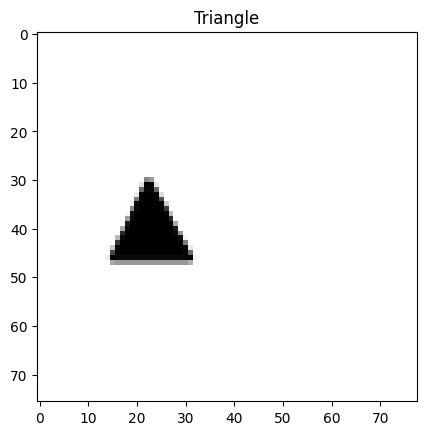

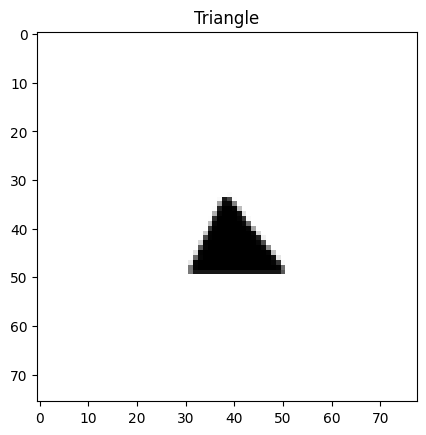

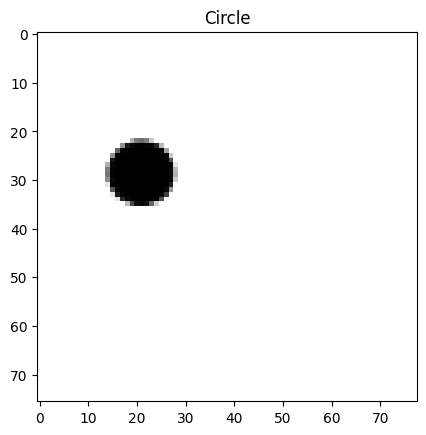

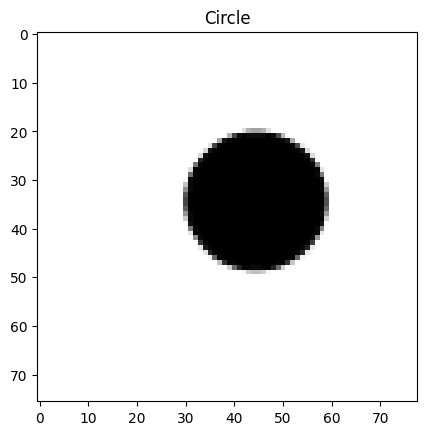

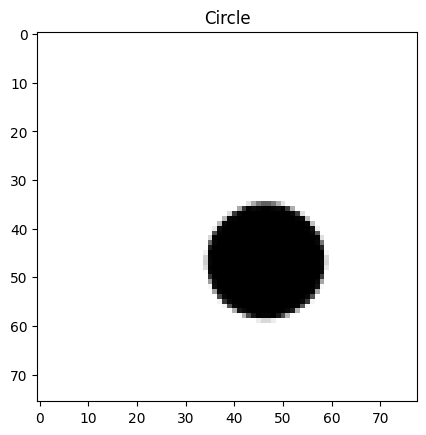

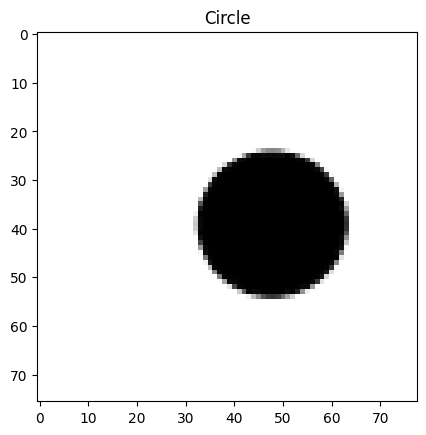

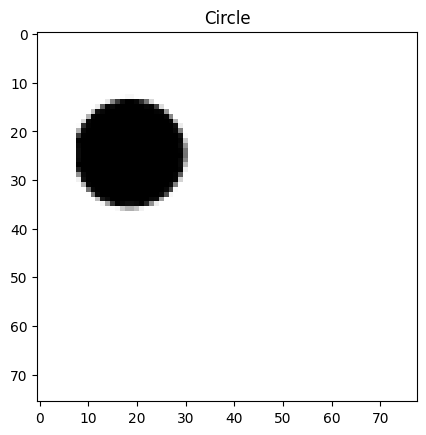

In [39]:
for iter_, (image, label) in enumerate(zip(X, y)):
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.title('Triangle' if label == 1 else 'Circle')
    plt.show()

    if iter_ > 5:
        break

❓ **Question: How many classes are we going to predict** ❓

_This information will help us design the last layer of your Convolutional Network_

In [40]:
np.unique(y, return_counts = True)
# Two categories to predict

(array([0, 1]), array([100, 100]))

<details>
    <summary><i>Answer</i></summary>
        
- We have only two categories: Triangle (1) and Circle (0).  
- Hence, it is a binary classification and we will need only one single neuron in the predictive layer.
        
</details>        

## (1) Kernels & Convolutions

🎁 The following function **`compute_convolution`** performs a **convolution operation** $ \Leftrightarrow $ i.e. *it applies a kernel to an image*.

❓ **Question about the `compute_convolution` function** ❓

Run it and try to understand the different steps of this function.

In [41]:
def compute_convolution(input_image, kernel):
    """
    Computes the 2D convolution of an image with a given kernel.

    Args:
        input_image: A 3D NumPy array representing the image (height, width, channels).
        kernel: A 2D NumPy array representing the filter to apply.

    Returns:
        A 2D list representing the feature map or convolved output.
    """
    # --- 1. Initialization ---

    kernel = np.array(kernel)
    # Get the dimensions (height, width) of the kernel. This determines the size of the sliding window.
    kernel_height, kernel_width = kernel.shape

    # --- 2. Prepare the Input Image ---

    # Use np.squeeze() to remove single-dimensional entries from the shape of the array.
    # For an image (e.g., shape 76x78x1), this simplifies it to a 2D array (76x78) for easier processing.
    img = np.squeeze(input_image)
    # Get the dimensions of the simplified 2D image.
    img_height, img_width = img.shape

    # --- 3. Perform the Convolution ---

    # Create an empty list that will hold the rows of the final convolved image (the feature map).
    output_image = []

    # Slide the kernel vertically across the image.
    # The range is calculated to stop when the bottom of the kernel reaches the bottom of the image.
    for x in range(img_height - kernel_height + 1):
        # For each vertical step, create a list to hold the values for the current output row.
        arr = []

        # Slide the kernel horizontally across the image.
        # The range stops when the right side of the kernel reaches the right side of the image.
        for y in range(img_width - kernel_width + 1):

            # --- 4. The Core Convolution Operation ---

            # First, slice the image to get a patch that is the same size as the kernel.
            # This patch is the region of the image currently "under" the kernel.
            image_patch = img[x: x + kernel_height, y: y + kernel_width]

            # Perform element-wise multiplication between the image patch and the kernel.
            # Then, sum up all the elements of the resulting matrix. This single sum is the convolved value.
            #
            convolved_value = np.multiply(image_patch, kernel).sum()

            # Append the calculated value to the current output row.
            arr.append(convolved_value)

        # Once a full row is computed, append it to the final output image.
        output_image.append(arr)

    # Return the completed feature map.
    return output_image

❓ **How does the `compute_convolution` function work in practice** ❓

1. Choose any image from the input dataset
2. Apply the `identity_kernel` to it
3. Display both the input image and the output image.
4. Do you see any differences?

In [42]:
identity_kernel = [
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]

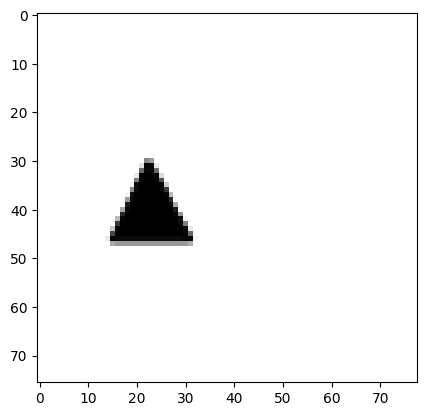

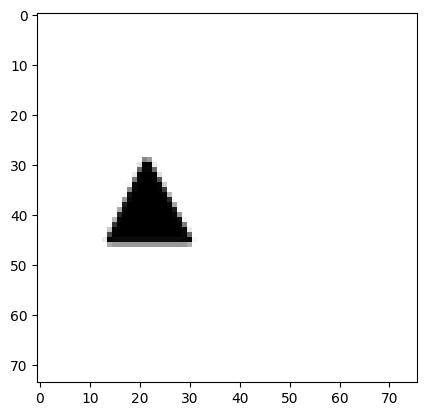

In [43]:
input_image = X[0]
kernel = identity_kernel

output_image = compute_convolution(input_image, kernel)

# Original Image
plt.imshow(np.squeeze(X[0]), cmap='gray')
plt.show()

# Convoluted image
plt.imshow(output_image, cmap='gray')
plt.show()

<details>
    <summary><i>Answer</i></summary>
        
🧑🏻‍🏫 The previous kernel corresponds to the **`identity_kernel`**, meaning that ***the output is equal to the input***...
    
🕵🏻‍♂️ It basically did nothing to the input image. It you think about it thoroughly, that's not surprising. With this kernel, only the pixel scanned in the middle was kept and multiplied by one, the surrounding pixels were multiplied by zero.        
        
</details>        

🎁The function **`plot_convolution`** plots the output image after applying a kernel to an input image.

In [44]:
def plot_convolution(img, kernel, activation=False):
    ''' The following printing function ease the visualization'''

    img = np.squeeze(img)
    output_img = compute_convolution(img, kernel)
    if activation:
        output_img = np.maximum(output_img, 0)

    plt.figure(figsize=(10, 5))

    ax1 = plt.subplot2grid((3,3),(0,0), rowspan=3)
    ax1.imshow(img, cmap='gray')
    ax1.title.set_text('Input image')

    ax2 = plt.subplot2grid((3,3),(1, 1))
    ax2.imshow(kernel, cmap='gray')
    ax2.title.set_text('Kernel')

    ax3 = plt.subplot2grid((3,3),(0, 2), rowspan=3)
    ax3.imshow(output_img, cmap='gray')
    ax3.title.set_text('Output image')

    for ax in [ax1, ax2, ax3]:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    plt.show()

❓ **Question** ❓ Apply `plot_convolution` with the following `kernel_1` once on an triangle and once on a circle.


In [ ]:
kernel_1 = [
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
]

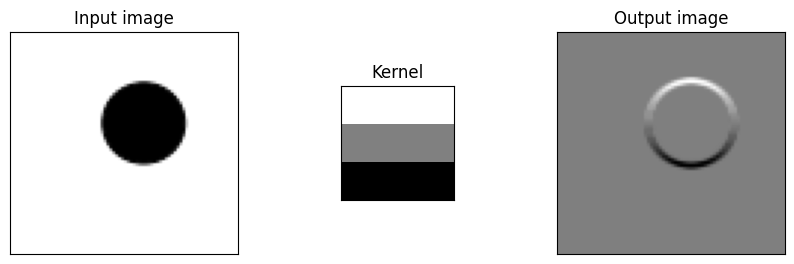

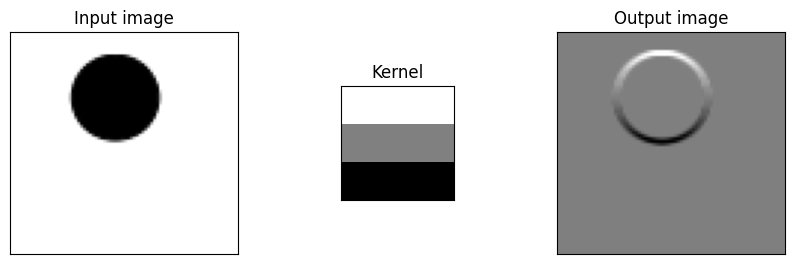

In [ ]:
plot_convolution(X[0], kernel_1)
plot_convolution(X[5], kernel_1)

👆 Let's analyze what just happened:

* White pixels correspond to high values and black pixels to low values.
* In a Neural Network, remember that we use activation functions to remove linearities.
    * *For example*, when the activation function is `relu`, you already know that it simply corresponds to setting the negative values to 0.

---

❓ **What is the impact of the activation function in a Convolutional Layer ?** ❓

Re-run the previous function `plot_convolution` with `activation` set to `True` (in this case, the activation function _is_ the relu).

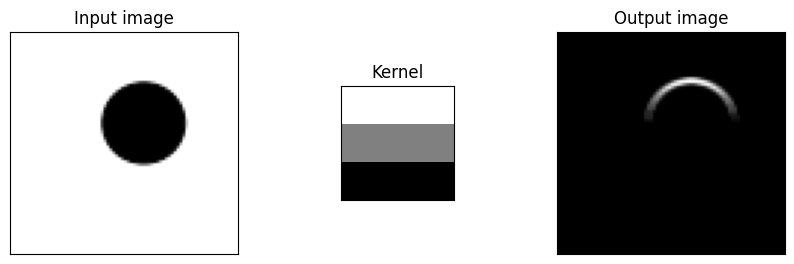

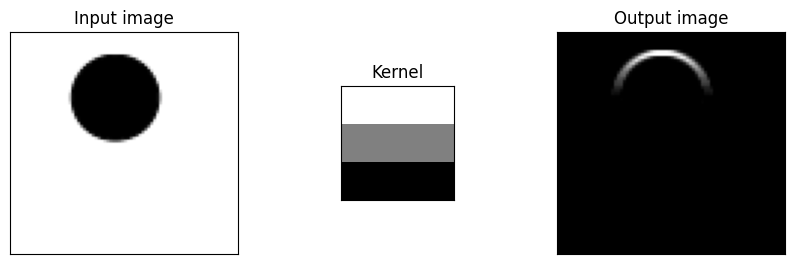

In [ ]:
plot_convolution(X[0], kernel_1, activation=True)
plot_convolution(X[5], kernel_1, activation=True)

👆 This kernel is actually highlighting the edges in a given direction.

❓ **Play with different kernels...** ❓

Try the following kernels to check the different edges they can detect.

In [ ]:
kernel_2 = [
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1],
]

kernel_3 = [
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
]

kernel_4 = [
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
]

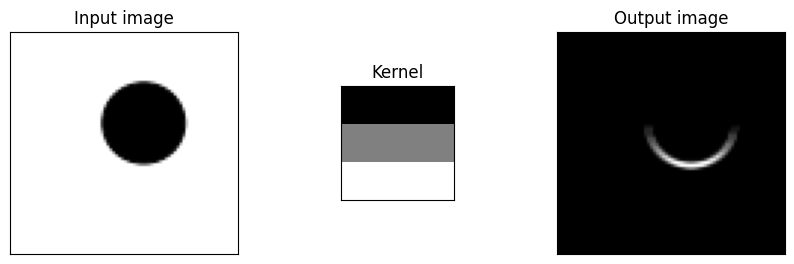

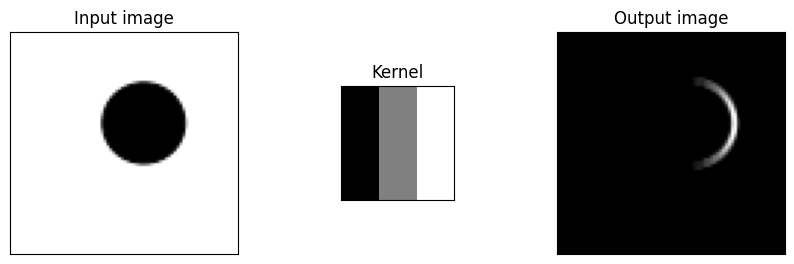

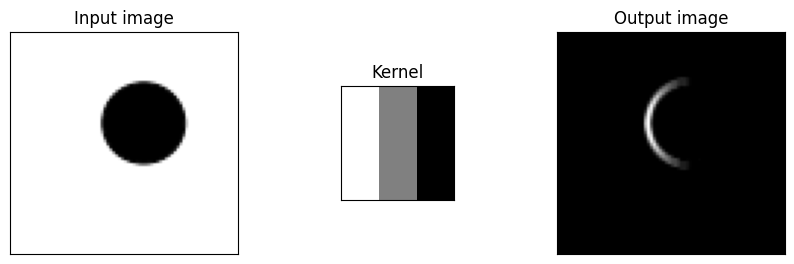

In [ ]:
plot_convolution(X[0], kernel_2, activation=True)
plot_convolution(X[0], kernel_3, activation=True)
plot_convolution(X[0], kernel_4, activation=True)

❓ **What is the effect of the kernel size** ❓

Try the _kernel_big_.

In [ ]:
kernel_big = np.array([
    np.ones((10,)),
    np.ones((10,)),
    np.ones((10,)),
    
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    
    np.ones((10,))*-1,
    np.ones((10,))*-1,
    np.ones((10,))*-1,
])

kernel_big

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

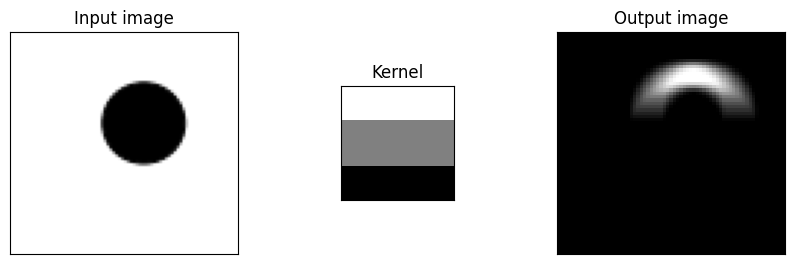

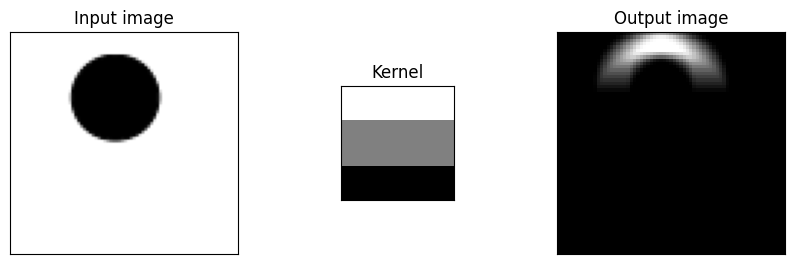

In [ ]:

plot_convolution(X[0], kernel_big, activation=True)
plot_convolution(X[5], kernel_big, activation=True)


❓ **Try another kernel**  ❓

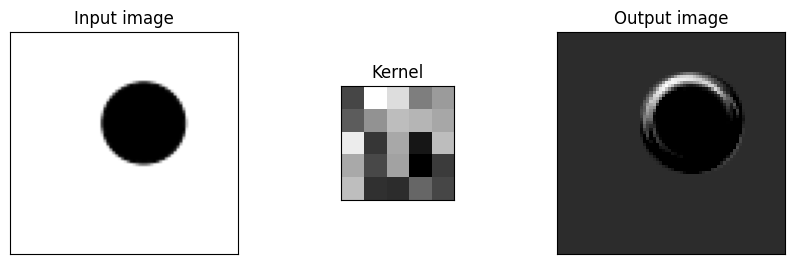

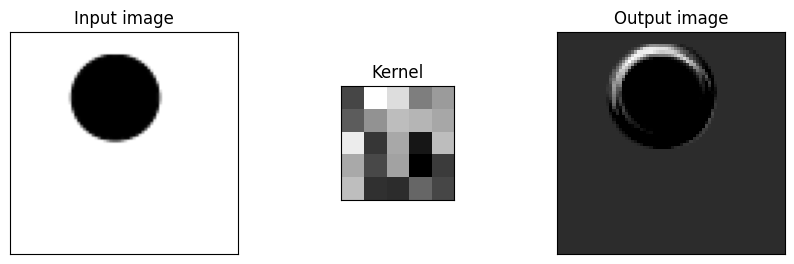

In [ ]:
random_kernel = np.random.uniform(-10, 10, (5, 5))

plot_convolution(X[0], random_kernel, activation=True)
plot_convolution(X[5], random_kernel, activation=True)


Now that you've got the idea of what a convolution operation does to an image, let's see how it goes with a "real" Convolutional Neural Network. ✅

## (2) Training a CNN to detect triangles and circles

### (2.1) Architecture


❓ **Question: Designing a CNN** ❓

Write a Convolutional Network that has
- a Convolutional Layer with 16 filters with $ (4, 4) $ kernels.
- a Convolutional Layer with 32 filters with $ (3, 3) $ kernels.
- a Convolutional Layer with 64 filters with $ (3, 3) $ kernels.
- a Convolutional Layer with 64 filters with $ (2, 2) $ kernels.

with:
- A Max-Pooling Layer (with a $ (2, 2) $ pool-size) after each convolution.
- A Hidden Dense Layer with the size of your choice, be reasonable:
    - after the flattening part
    - but before the last layer


Also, make sure to compile your model with the appropriate parameters

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import copy

In [64]:
# Define the model architecture as a class
class PyTorchCNN(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class (nn.Module)
        super(PyTorchCNN, self).__init__()

        # --- Convolutional and Pooling Layers ---
        # Note: PyTorch expects input as (Channels, Height, Width)
        # Keras: Conv2D(filters, kernel_size)
        # PyTorch: Conv2d(in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(4, 4))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(2, 2))
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

        # --- Fully Connected (Dense) Layers ---
        # Keras: Dense(units)
        # PyTorch: Linear(in_features, out_features)
        # We need to calculate the input features for the first linear layer.
        # After the final pool layer, the output shape is (64, 3, 3).
        # So, the number of features is 64 * 3 * 3 = 576.
        self.fc1 = nn.Linear(in_features=64 * 3 * 3, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=1)

    # Define the forward pass
    def forward(self, x):
        # Apply convolution, activation (ReLU), and pooling for each block
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        # Flatten the output from the conv blocks to prepare for the dense layers
        # The -1 infers the batch size
        x = x.view(-1, 64 * 3 * 3)

        # Apply dense layer with ReLU activation
        x = F.relu(self.fc1(x))

        # Apply final output layer with Sigmoid activation for binary classification
        x = torch.sigmoid(self.fc2(x))

        return x

# --- Equivalent of the Keras initialize_model() function ---

def initialize_model():
    """
    Initializes the PyTorch model, loss function, and optimizer.
    This replaces the single Keras function that also compiled the model.
    """
    # 1. Initialize the model architecture
    model = PyTorchCNN()

    # 2. Define the loss function (equivalent to `loss='binary_crossentropy'`)
    loss_function = nn.BCELoss()

    # 3. Define the optimizer (equivalent to `optimizer='adam'`)
    # We pass the model's parameters to the optimizer so it knows what to update.
    optimizer = torch.optim.Adam(model.parameters())

    # In PyTorch, metrics like 'accuracy' are calculated manually within the training loop.

    return model, loss_function, optimizer

# --- Example of how to use it ---

# Get the initialized model, loss, and optimizer
model, criterion, optimizer = initialize_model()

# You can print the model to see its structure
print(model)

# To use the model, you would create a dummy input tensor
# PyTorch requires (batch_size, channels, height, width)
dummy_input = torch.randn(1, 1, 76, 78)
output = model(dummy_input)

print("\nOutput shape:", output.shape)

PyTorchCNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

Output shape: torch.Size([1, 1])


### (2.2) Training

In [8]:
# Parameters on the first Conv2D
( (4*4) * 1 + 1) * 16

272

In [9]:
# Parameters on the second Conv2D
( (3*3) * 16 + 1) * 32

4640

In [10]:
# Parameters on the third Conv2D
( (3*3) * 32 + 1) * 64


18496

In [11]:
# Parameters on the fourth and last Conv2D
( (2*2) * 64 + 1) * 64

16448

❓ **Question: Training the CNN** ❓

* Fit the model. We achieve an accuracy of *at least* 90%.

    * When you reach such a high score, it may sound suspicious and you would probably ask yourself whether the model is overfitting or not... but let's ignore it for this exercise 😏

In [12]:
# This helper class is needed for early stopping
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            # Save the best model state
            self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"INFO: Early stopping triggered after {self.patience} epochs of no improvement.")
                self.early_stop = True


In [13]:
# --- 1. Data Preparation ---

X_tensor = torch.from_numpy(X.astype(np.float32)).permute(0, 3, 1, 2)

y_tensor = torch.from_numpy(y.astype(np.float32)).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)

# Perform a 70/30 split for training and validation (like validation_split=0.3)
val_percent = 0.3
val_size = int(len(dataset) * val_percent)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders to handle batching (like batch_size=16)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# --- 2. Initialization ---
model, criterion, optimizer = initialize_model()
early_stopper = EarlyStopper(patience=5)

# --- 3. Training Loop ---
epochs = 50
# Add keys for accuracy to the history dictionary
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print("Starting training...")
for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    correct_train = 0 # New: for accuracy
    total_train = 0   # New: for accuracy

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)

        # New: Calculate training accuracy
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    correct_val = 0 # New: for accuracy
    total_val = 0   # New: for accuracy
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

            # New: Calculate validation accuracy
            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # --- Record and Print Epoch Stats ---
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_train_acc = correct_train / total_train # New
    epoch_val_acc = correct_val / total_val     # New

    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['train_acc'].append(epoch_train_acc) # New
    history['val_acc'].append(epoch_val_acc)   # New

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

    # --- Early Stopping Check ---
    early_stopper(epoch_val_loss, model)
    if early_stopper.early_stop:
        break

# After the loop, load the best model weights found during training
if early_stopper.best_model_state:
    print("\nINFO: Loading best model state.")
    model.load_state_dict(early_stopper.best_model_state)

print("\nTraining finished.")

Starting training...
Epoch 1/50 | Train Loss: 0.9286 | Val Loss: 0.5703 | Train Acc: 0.5286 | Val Acc: 0.7833
Epoch 2/50 | Train Loss: 0.4993 | Val Loss: 0.4330 | Train Acc: 0.7857 | Val Acc: 0.8000
Epoch 3/50 | Train Loss: 0.2969 | Val Loss: 0.1457 | Train Acc: 0.9143 | Val Acc: 0.9500
Epoch 4/50 | Train Loss: 0.1027 | Val Loss: 0.1504 | Train Acc: 0.9714 | Val Acc: 0.9167
Epoch 5/50 | Train Loss: 0.0980 | Val Loss: 0.0395 | Train Acc: 0.9429 | Val Acc: 1.0000
Epoch 6/50 | Train Loss: 0.0301 | Val Loss: 0.0113 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 7/50 | Train Loss: 0.0067 | Val Loss: 0.0045 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 8/50 | Train Loss: 0.0028 | Val Loss: 0.0025 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 9/50 | Train Loss: 0.0013 | Val Loss: 0.0018 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 10/50 | Train Loss: 0.0008 | Val Loss: 0.0018 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 11/50 | Train Loss: 0.0006 | Val Loss: 0.0017 | Train Acc: 1.0000 | Val Acc: 1.000

🎁 We have the `plot_loss_accuracy` function.

❓ **Question: does the CNN converge** ❓

_Also, do you see any sign of overfitting?_

In [14]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history, title=None):
    """
    Plots the training and validation loss and accuracy from a PyTorch history dictionary.
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))

    # --- LOSS ---
    ax[0].plot(history['train_loss'])
    ax[0].plot(history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0, 3))
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)

    # --- ACCURACY ---
    ax[1].plot(history['train_acc'])
    ax[1].plot(history['val_acc'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].set_ylim((0, 1))
    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)

    if title:
        fig.suptitle(title)

    plt.show()

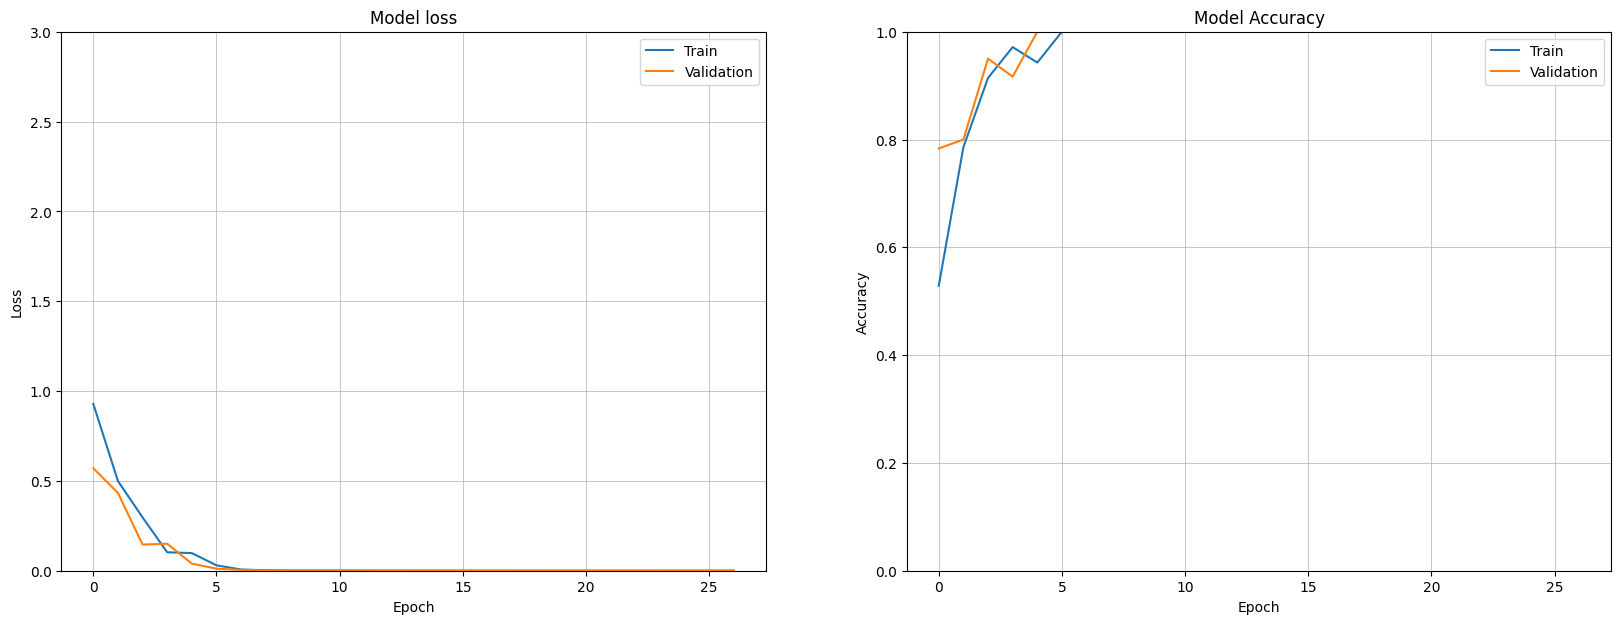

We are not overfitting ;)


In [15]:
plot_loss_accuracy(history)

print("We are not overfitting ;)")

### 🎁 📚 (2.3) Deeper understanding of CNNs

👩🏻‍🏫 For any Sequential Neural Network (Dense or Convolutional), you can:
- print the **`.summary()`** to display the layers and the number of weights/parameters involved
- access the different **`.layers`** of your model

In [16]:
summary(model, input_size=(1, 76, 78))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 73, 75]             272
         MaxPool2d-2           [-1, 16, 36, 37]               0
            Conv2d-3           [-1, 32, 34, 35]           4,640
         MaxPool2d-4           [-1, 32, 17, 17]               0
            Conv2d-5           [-1, 64, 15, 15]          18,496
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 64, 6, 6]          16,448
         MaxPool2d-8             [-1, 64, 3, 3]               0
            Linear-9                   [-1, 10]           5,770
           Linear-10                    [-1, 1]              11
Total params: 45,637
Trainable params: 45,637
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.35
Params size (MB): 0.17
Estimated Tot

#### (2.3.1) Kernels

🧑🏻‍🏫 It is possible to **retrieve the values of all the kernels for each layer after training a CNN**.

👉 Let's focus first on the different parameters (**`.weights`**) of the first convolutional layer.

In [18]:
# 1. Access the first convolutional layer by its attribute name
first_conv_layer = model.conv1
print(f"First layer object: {first_conv_layer}\n")

First layer object: Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))



In [19]:
# 2. Access the kernels (weights) and their shape
kernels = first_conv_layer.weight
print(f"Kernels tensor shape: {kernels.shape}")

Kernels tensor shape: torch.Size([16, 1, 4, 4])


👆 `torch.Size([16, 1, 4, 4])` represents:
- the weights of each kernel (size `4` $\times$ `4`)
- there was only `1` channel (single B&W input)
- and we have decided to apply `16` different kernels in this layer!

In [20]:
# 3. Access the biases and their shape
biases = first_conv_layer.bias
print(f"Biases tensor shape: {biases.shape}")

Biases tensor shape: torch.Size([16])


👆 Let's not forget the biases, one per new channel in the output image!

In [21]:
# Notice that we have indeed 256 weights + 16 biases = 272 parameters for the first convolutional layer
4*4*1*16+16

272

👉 What are the parameters for the other layers of this Network ❓

In [23]:
# 1. Access the second convolutional layer by its attribute name
second_convolutional_layer = model.conv2
print(f"Second layer object: {second_convolutional_layer}\n")

Second layer object: Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))



In [24]:
# 2. Access the kernels (weights) and their shape
kernels = second_convolutional_layer.weight
print(f"Kernels tensor shape: {kernels.shape}")

Kernels tensor shape: torch.Size([32, 16, 3, 3])


In [25]:
# 3. Access the biases and their shape
biases = second_convolutional_layer.bias
print(f"Biases tensor shape: {biases.shape}")

Biases tensor shape: torch.Size([32])


In [26]:
# Notice that we have indeed 4608 weights + 32 biases = 4640 parameters for the third convolutional layer
3*3*16*32+32

4640

In [27]:
# 1. Access the second convolutional layer by its attribute name
third_convolutional_layer = model.conv3
print(f"Third layer object: {third_convolutional_layer}\n")

Third layer object: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))



In [28]:
# 2. Access the kernels (weights) and their shape
kernels = third_convolutional_layer.weight
print(f"Kernels tensor shape: {kernels.shape}")

Kernels tensor shape: torch.Size([64, 32, 3, 3])


In [29]:
# 3. Access the biases and their shape
biases = third_convolutional_layer.bias
print(f"Biases tensor shape: {biases.shape}")

Biases tensor shape: torch.Size([64])


In [30]:
# Notice that we have indeed 18432 weights + 64 biases = 18496 parameters for the fourth convolutional layer
3*3*32*64+64

18496

In [31]:
# 1. Access the second convolutional layer by its attribute name
fourth_convolutional_layer = model.conv4
print(f"Fourth layer object: {fourth_convolutional_layer}\n")

Fourth layer object: Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))



In [32]:
# 2. Access the kernels (weights) and their shape
kernels = fourth_convolutional_layer.weight
print(f"Kernels tensor shape: {kernels.shape}")

Kernels tensor shape: torch.Size([64, 64, 2, 2])


In [33]:
# 3. Access the biases and their shape
biases = fourth_convolutional_layer.bias
print(f"Biases tensor shape: {biases.shape}")

Biases tensor shape: torch.Size([64])


In [34]:
# Notice that we have indeed 16384 weights + 64 biases = 16448 parameters for the fourth convolutional layer
(2*2*64+1)*64

16448

🚀 Now that we know how to access the trained weights of each kernel for every convolutional layer, we are going to investigate how they impact the analysis of images.

* 🪄 Using **`plot_convolution(activation = True)`**, let's display the 16 kernels from the first convolutional layer, alongside with the activation output, to see what the model has learned from the images in this layer.

------------------------- Effect of the kernel number 0 -------------------------


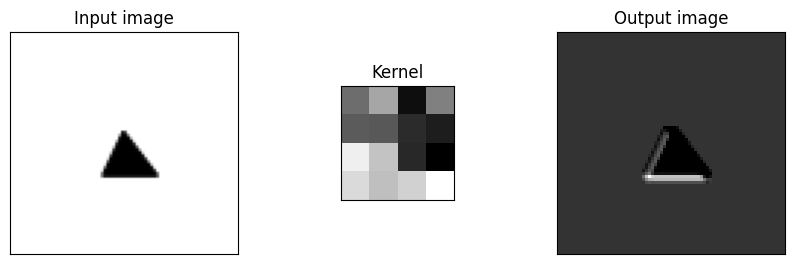

------------------------- Effect of the kernel number 1 -------------------------


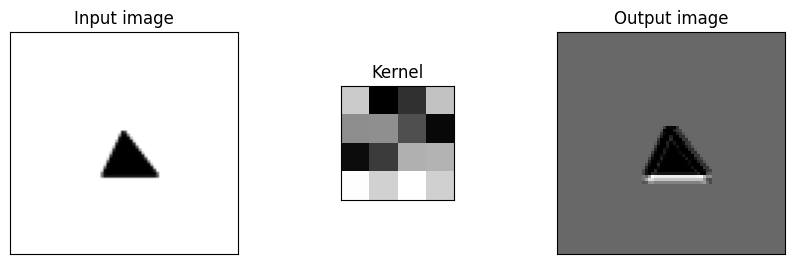

------------------------- Effect of the kernel number 2 -------------------------


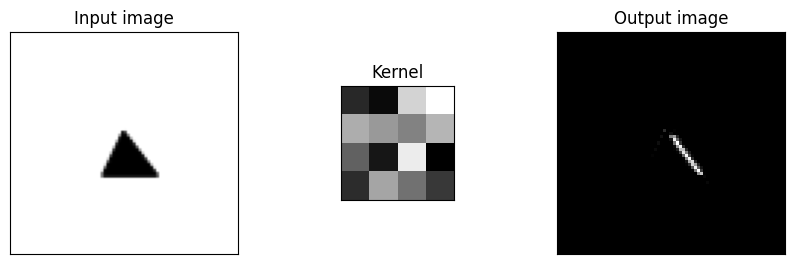

------------------------- Effect of the kernel number 3 -------------------------


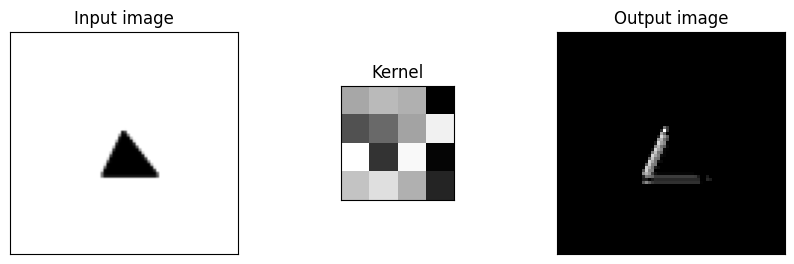

------------------------- Effect of the kernel number 4 -------------------------


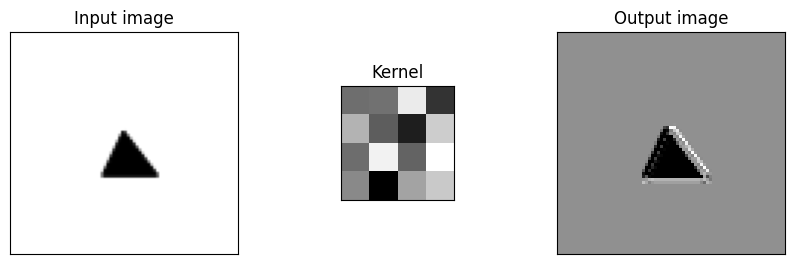

------------------------- Effect of the kernel number 5 -------------------------


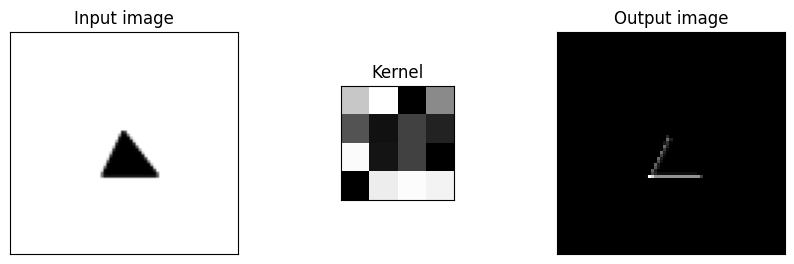

------------------------- Effect of the kernel number 6 -------------------------


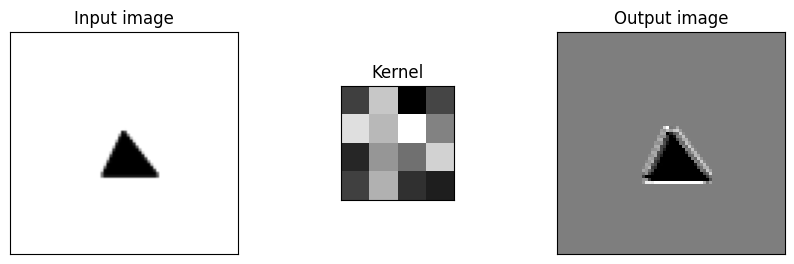

------------------------- Effect of the kernel number 7 -------------------------


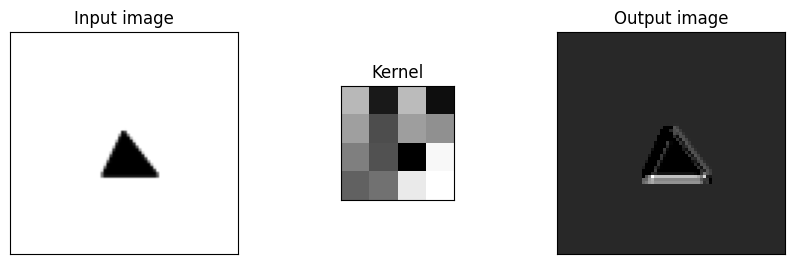

------------------------- Effect of the kernel number 8 -------------------------


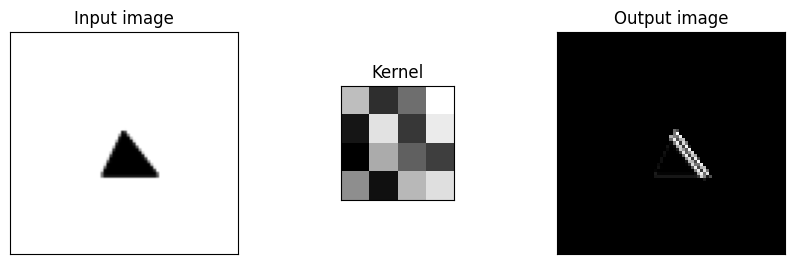

------------------------- Effect of the kernel number 9 -------------------------


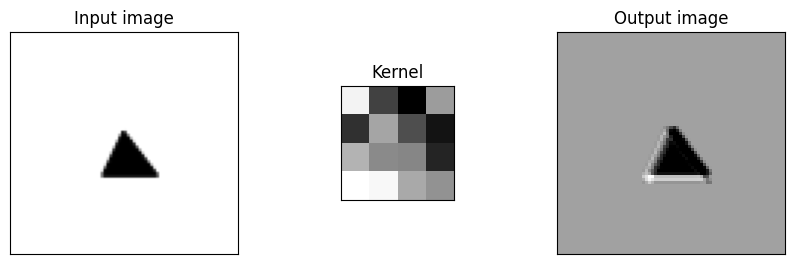

------------------------- Effect of the kernel number 10 -------------------------


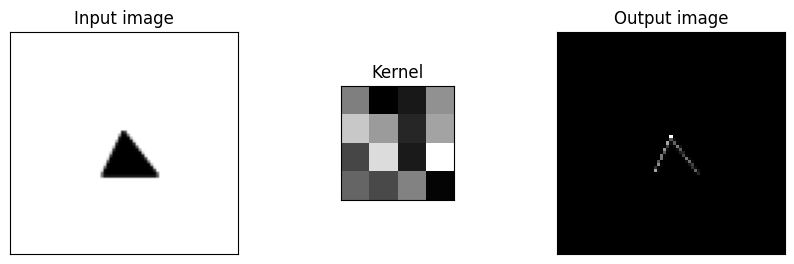

------------------------- Effect of the kernel number 11 -------------------------


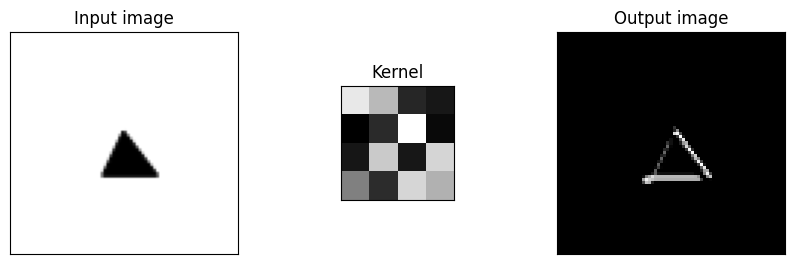

------------------------- Effect of the kernel number 12 -------------------------


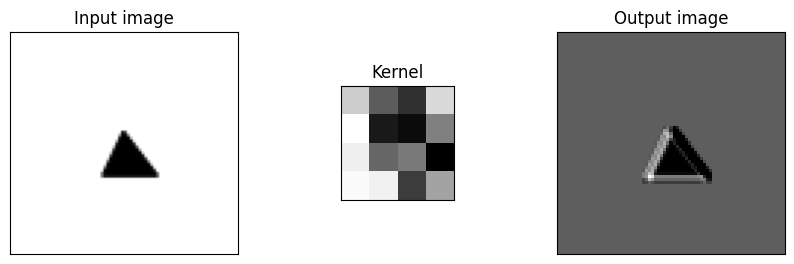

------------------------- Effect of the kernel number 13 -------------------------


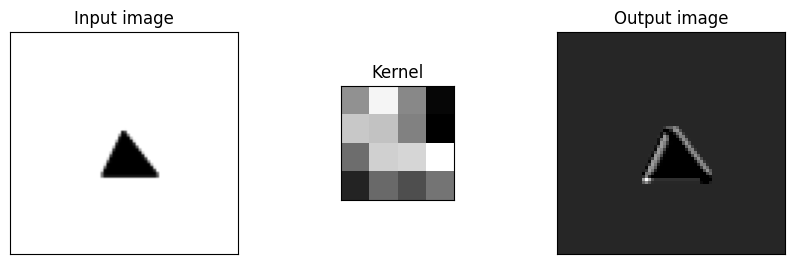

------------------------- Effect of the kernel number 14 -------------------------


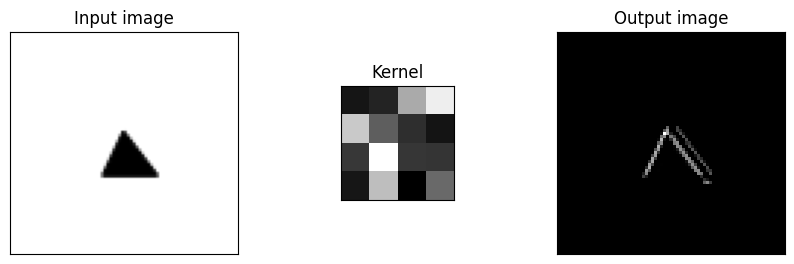

------------------------- Effect of the kernel number 15 -------------------------


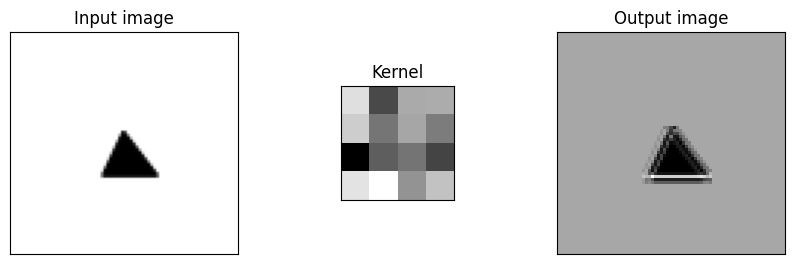

In [45]:
all_kernels = model.conv1.weight.detach().numpy()

# The input image has only 1 channel
channel_number = 0

# Get a single image to test on (assuming X has shape N, H, W, C)
image_to_test = X[1].squeeze() # Squeeze to remove the channel dim for plotting

# Loop through all 16 kernels of the first layer
# all_kernels.shape[0] is the number of output channels (16 in this case)
for k in range(all_kernels.shape[0]):
    print(f"------------------------- Effect of the kernel number {k} -------------------------")
    
    # Extract the k-th kernel for the given input channel
    kernel = all_kernels[k, channel_number, :, :]
    
    # Use your existing plotting function
    plot_convolution(image_to_test, kernel, activation=True)

#### (2.3.2) Activations 🧨

We have been looking at the activation ("_output image_") only after the **first convolutional layer**.

🤔 What if we want to **visualize the activation of an image after every convolutional layer of the CNN** ?

***Step 0️⃣ : Reminders of the CNN's summary***

In [46]:
summary(model, input_size=(1, 76, 78))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 73, 75]             272
         MaxPool2d-2           [-1, 16, 36, 37]               0
            Conv2d-3           [-1, 32, 34, 35]           4,640
         MaxPool2d-4           [-1, 32, 17, 17]               0
            Conv2d-5           [-1, 64, 15, 15]          18,496
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 64, 6, 6]          16,448
         MaxPool2d-8             [-1, 64, 3, 3]               0
            Linear-9                   [-1, 10]           5,770
           Linear-10                    [-1, 1]              11
Total params: 45,637
Trainable params: 45,637
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.35
Params size (MB): 0.17
Estimated Tot

In [56]:
# A. Create a dictionary to store the outputs
layer_outputs = {}

# B. Define the hook function
def get_activation(name):
    def hook(model, input, output):
        layer_outputs[name] = output.detach()
    return hook

# C. Register a hook for each convolutional layer in your model
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))
model.conv4.register_forward_hook(get_activation('conv4'))

# D. Perform a forward pass with a single image to trigger the hooks
# Use the first image from your data and add a batch dimension
sample_input = X_tensor[10].unsqueeze(0) 
_ = model(sample_input)

The layer_outputs dictionary will contain the activation tensors from each of the four convolutional layers.

In [57]:
# layer_outputs

### Create the Visualization Function

Next, this function will loop through your captured activations. For each layer, it will create a grid of subplots to display all of its feature maps.

In [58]:
import math


def visualize_activations(layer_outputs):
    """
    Plots the feature maps from each layer's activation.
    """
    # Loop through each layer's name and its corresponding activation tensor
    for layer_name, activation in layer_outputs.items():
        # The activation tensor has shape (1, num_channels, height, width)
        num_feature_maps = activation.shape[1]
        
        # Calculate the grid size for the subplots (e.g., 16 maps -> 4x4 grid)
        grid_size = math.ceil(math.sqrt(num_feature_maps))
        
        # Create a figure to display the feature maps
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
        fig.suptitle(f'Activations of {layer_name} ({num_feature_maps} feature maps)', fontsize=16)

        # Loop through each feature map in the activation tensor
        for i in range(num_feature_maps):
            # Get the specific feature map
            # Squeeze() removes the batch dimension of 1
            feature_map = activation.squeeze(0)[i]
            
            # Find the correct subplot to draw on
            ax = axes[i // grid_size, i % grid_size]
            
            # Plot the feature map as a grayscale image
            ax.imshow(feature_map, cmap='gray')
            ax.set_title(f'Map {i+1}', fontsize=8)
            ax.axis('off')
            
        # Clean up empty subplots
        for i in range(num_feature_maps, grid_size*grid_size):
            ax = axes[i // grid_size, i % grid_size]
            ax.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()



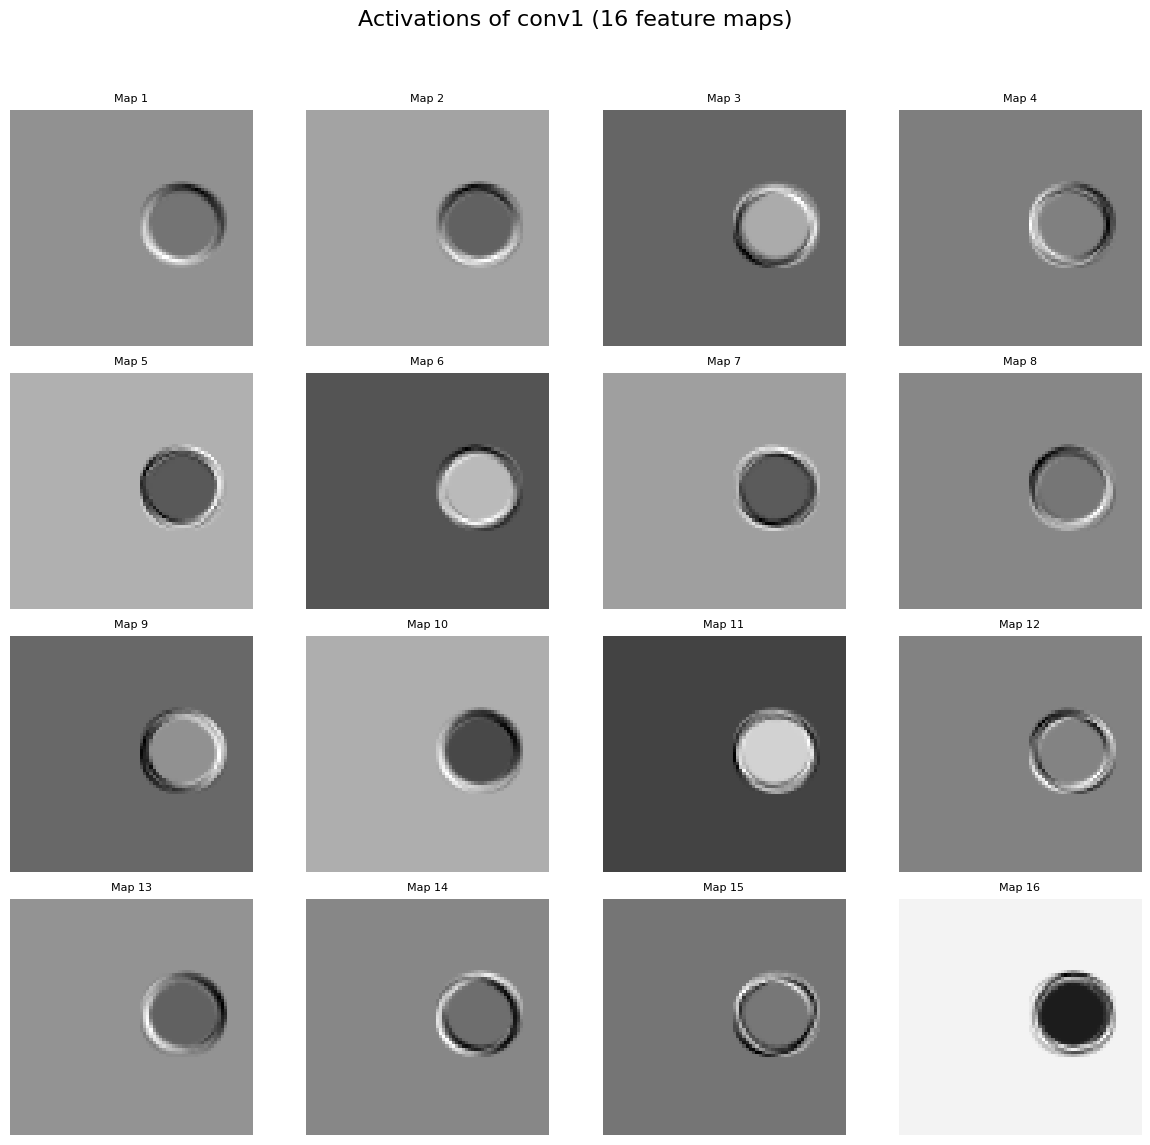

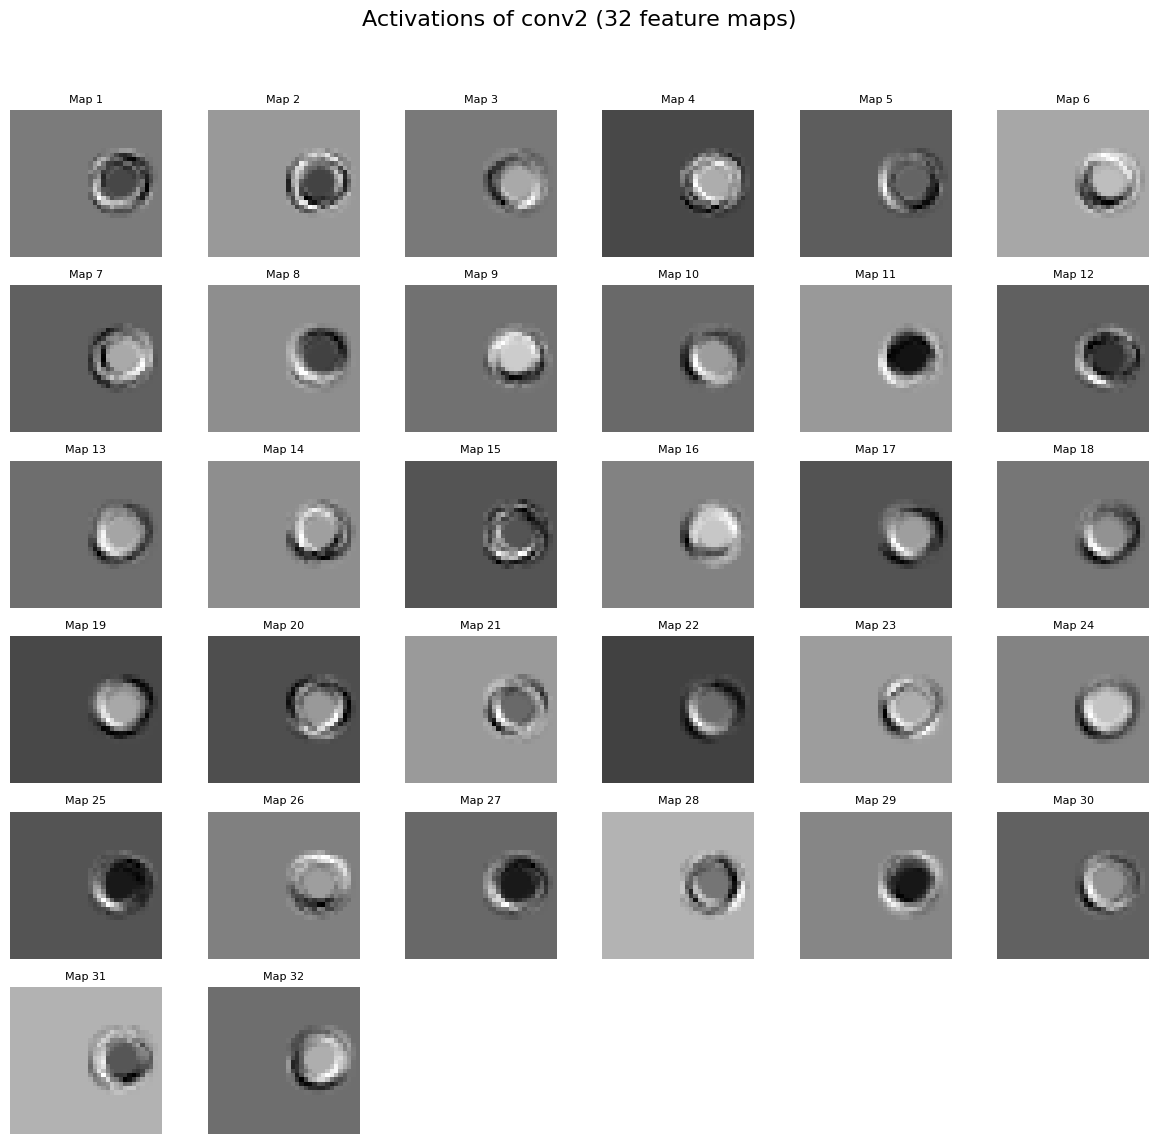

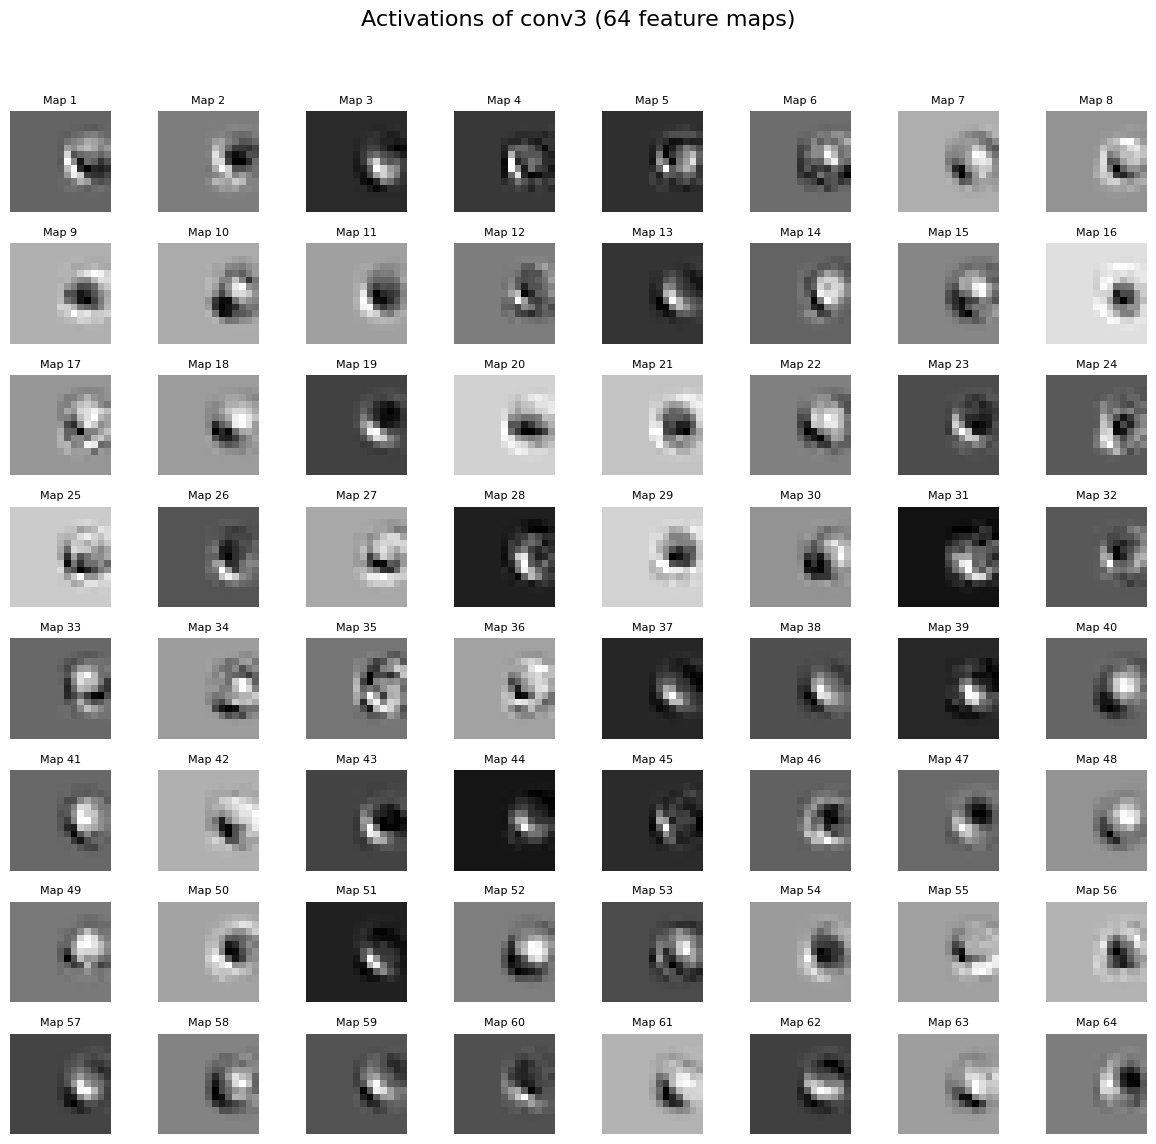

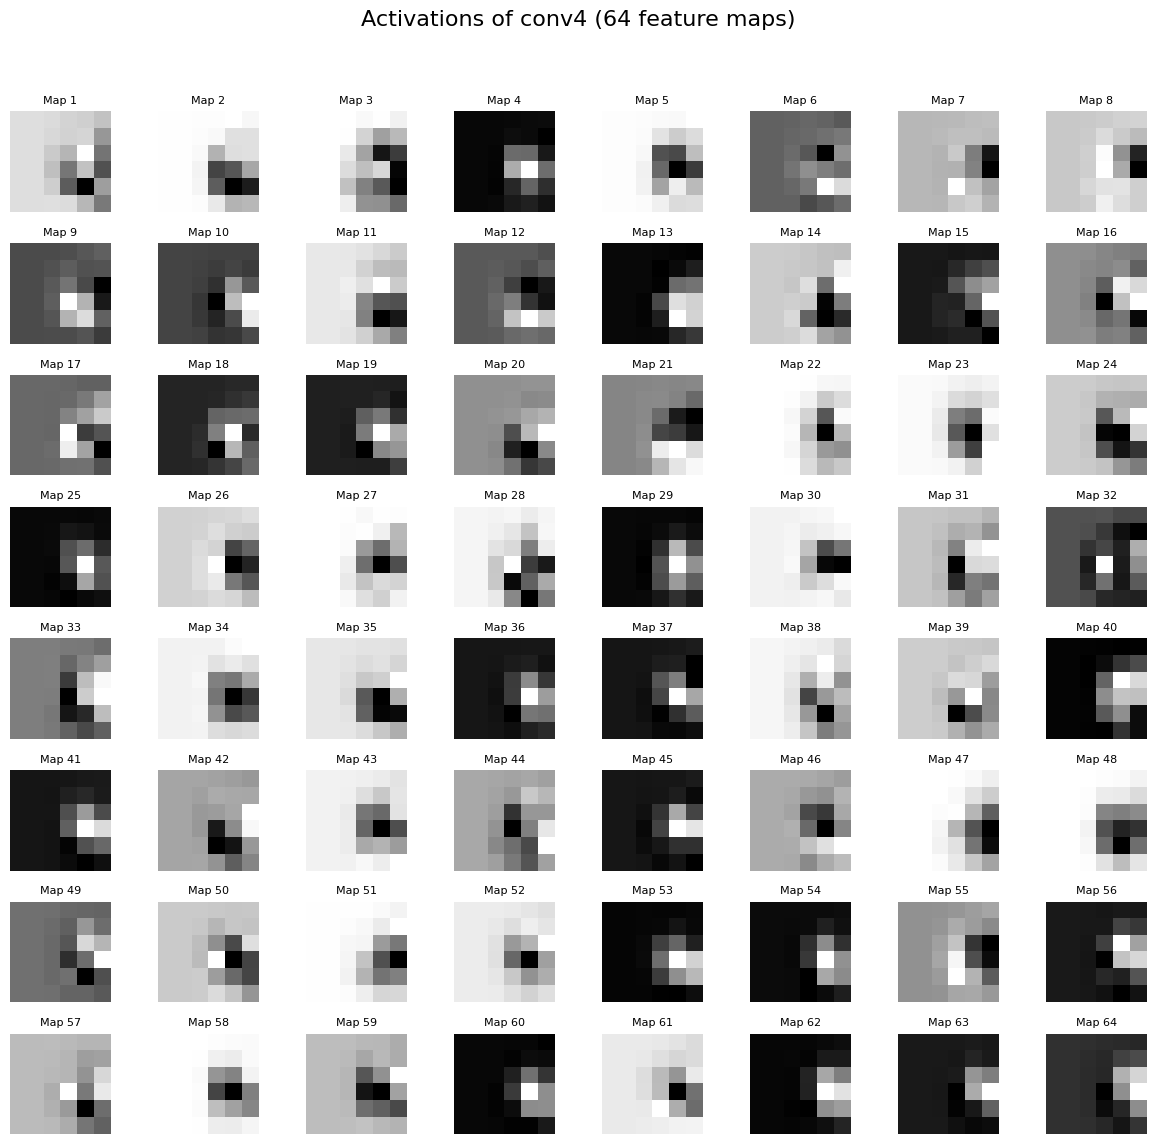

In [59]:
# --- 3. Run the visualization ---
visualize_activations(layer_outputs)

🧑🏻‍🏫 ***Notes*** 🧑🏻‍🏫

1. Notice how the information of an image **flows** through the Convolutional Neural Network.
2. You should see the picture becoming more and more "abstract", of smaller and smaller "dimensions"

🕹 Feel free to play with the [CNN Explainer](https://poloclub.github.io/cnn-explainer/) from researchers at [Georgia Tech](https://www.gatech.edu/)

## (Appendix) Utils

* The following section simply presents the functions that were used to create the dataset with triangles and circles.

* They are at the end of the notebook just in case you want to further prototype and get better understanding of what is going on.

In [ ]:
def draw_triangle():
    dx = np.random.uniform(0.1, 0.3)
    dy = np.random.uniform(0.1, 0.3)
    noise_x = np.random.uniform(0.0, 0.1)
    noise_y = np.random.uniform(0.0, 0.1)

    x = np.random.uniform(0, 1-dx-noise_x)
    y = np.random.uniform(0, 1-dy)
    X = np.array([[x,y], [x+dx+noise_x,y], [x+dx/2, y+dy+noise_y]])

    t1 = plt.Polygon(X, color='black')
    plt.gca().add_patch(t1)

def draw_circle():
    r = np.random.uniform(0.1, 0.25)
    x = np.random.uniform(0+r, 1-r)
    y = np.random.uniform(0+r, 1-r)

    circle1 = plt.Circle((x, y), r, color='black')
    plt.gcf().gca().add_artist(circle1)

def create_image(form, path):
    plt.figure(figsize=(1, 1))
    if form == 'circle':
        draw_circle()
    elif form == 'triangle':
        draw_triangle()
    plt.axis('off')
    plt.savefig(path, dpi=80, bbox_inches='tight')
    plt.close()


def create_images(path):
    nb_circles = 100
    nb_triangles = 100

    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        create_image('circle', c_path)

    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        create_image('triangle', t_path)